In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from goss import SimpleGOSS

data = pd.read_csv("./data/boston.csv")
X = data.drop("target", axis=1)
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SimpleGOSS(n_trees=70, learning_rate=0.1, a=0.2, b=0.4, max_depth=7, random_state=42)

In [2]:
model.fit(X_train, y_train)

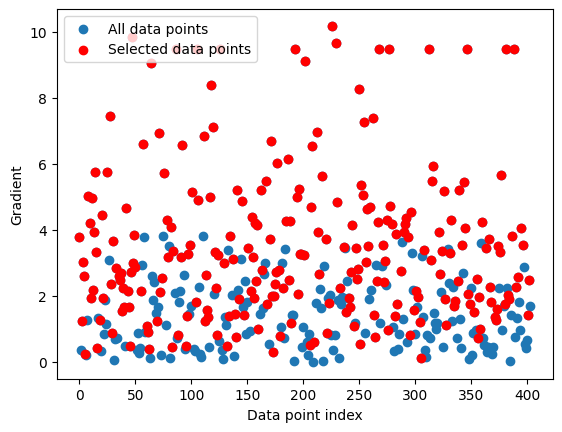

In [5]:
model.plot_grad_with_iter(10)

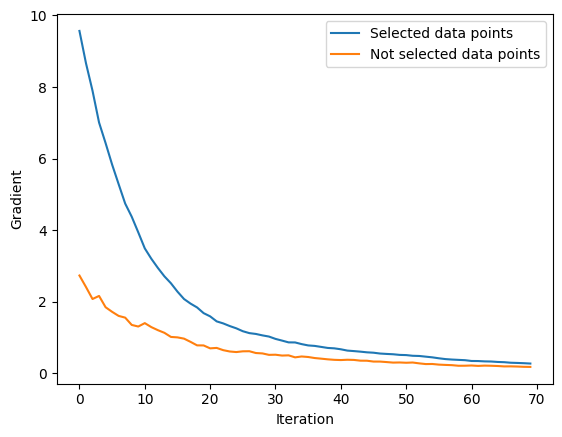

In [4]:
model.plot_grads()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def load_boston_dataset():
    data = fetch_openml(name='Boston', version=1, as_frame=False)
    X, y = data.data, data.target
    features = data.feature_names
    return X, y, features

In [ ]:
X, y, feats = load_boston_dataset()
df = pd.DataFrame(X, columns=feats)
df['target'] = y

df.to_csv('boston.csv', index=False)

In [ ]:
pd.Series(y)

In [ ]:
class SimpleGOSS:
    def __init__(self, n_trees=100, learning_rate=0.01, a=0.2, b=0.1, max_depth=4):
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.a = a
        self.b = b
        self.max_depth = max_depth
        self.trees = []
        self.costs = []

    # MSE
    def _calc_cost(self, y, y_pred):
        return np.mean((y - y_pred) ** 2)

    # MSEの負の勾配
    # MSEの勾配は: -2 * (y - y_pred) / len(y)
    # MSEの負の勾配を使っても良いが、定数倍は勾配降下法の学習率で調整できるため、簡潔に残差を使う。
    # ただし残差はMSEの負の勾配に比例するので、採用して問題ない。
    def _calc_gradients(self, y, y_pred):
        return y - y_pred
        # return 2 * (y - y_pred) / len(y)

    def _goss_sampling(self, X, top_n, rand_n, grads):
        top_indices = np.argpartition(np.abs(grads), -top_n)[-top_n:]
        rand_indices = np.setdiff1d(np.arange(len(X)), top_indices)
        # 論文に忠実な実装
        # rand_indices = np.random.choice(np.setdiff1d(np.arange(len(X)), top_indices), size=rand_n, replace=False)
        # こっちの方が精度が出る
        print(f"top_indices: {top_indices}, rand_indices: {rand_indices}")
        rand_indices = np.random.choice(rand_indices, size=rand_n, replace=False, p=np.abs(grads[rand_indices]) / np.abs(grads[rand_indices]).sum())
        used_indices = np.concatenate([top_indices, rand_indices])
        return used_indices

    def fit(self, X, y):
        # X = np.array(X)
        # y = np.array(y)
        np.random.seed(42)

        self.F0 = y.mean()
        Fm = np.repeat(self.F0, X.shape[0])

        top_n = int(self.a * len(X))
        rand_n = int(self.b * len(X))

        for _ in range(self.n_trees):
            grads = self._calc_gradients(y, Fm)

            used_indices = self._goss_sampling(X, top_n, rand_n, grads)

            # 重みを計算
            # ランダムサンプリングしたデータに重みをつける
            # 論文に忠実な実装
            # top_wight = np.repeat(self.a / top_n, top_n)
            # rand_weight = np.repeat((1 - self.a) / self.b, rand_n)
            # weight = np.concatenate([top_wight, rand_weight])
            # こっちの方が精度が出る
            weight = np.abs(grads[used_indices])

            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            tree.fit(X[used_indices], grads[used_indices], sample_weight=weight)

            self.costs.append(self._calc_cost(y[used_indices], Fm[used_indices]))

            # Fmを更新
            Fm += self.learning_rate * tree.predict(X)

            self.trees.append(tree)
        return self

    def predict(self, X):
        Fm = np.repeat(self.F0, X.shape[0])
        pred = Fm + self.learning_rate * np.sum([tree.predict(X) for tree in self.trees], axis=0)
        return pred

In [ ]:
from sklearn.model_selection import ParameterGrid

X, y = load_boston_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {'n_trees': [50, 70, 100, 150, 200, 300], 'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1], 'a': [0.1, 0.2, 0.3, 0.4], 'b': [0.1, 0.2, 0.3, 0.4], 'max_depth': list(np.arange(3, 10))}
grid = ParameterGrid(params)

best_score = 10000
best_param = None

total = len(grid)
for i, param in enumerate(grid):
    print(f'{i+1}/{total}')
    model = SimpleGOSS(**param)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred_test)

    if score < best_score:
        best_score = score
        best_param = param

In [ ]:
print(best_score)
print(best_param)

In [ ]:
# X, y = load_boston_dataset()
data = pd.read_csv("boston.csv")
X = data.drop("target", axis=1)
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

goss = SimpleGOSS(n_trees=70, learning_rate=0.1, a=0.2, b=0.4, max_depth=7)
goss.fit(X_train, y_train)
y_pred_train = goss.predict(X_train)
y_pred_test = goss.predict(X_test)

print(f"Train error: {mean_squared_error(y_train, y_pred_train):.2f}")
print(f"Test error: {mean_squared_error(y_test, y_pred_test):.2f}")

plt.plot(goss.costs)

In [ ]:
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train, y_train)
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)
print(f"Train error: {mean_squared_error(y_train, y_pred_train):.2f}")
print(f"Test error: {mean_squared_error(y_test, y_pred_test):.2f}")

In [ ]:
class GBDT:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.costs = []
    
    def _calc_cost(self, y, y_pred):
        return np.mean(np.abs(y - y_pred))
    
    def _calc_gradients(self, y, y_pred):
        return y - y_pred

    def fit(self, X, y):
        self.F0 = y.mean()
        Fm = np.repeat(self.F0, y.shape[0])

        for _ in range(self.n_estimators):
            # 残差を計算
            grads = self._calc_gradients(y, Fm)
            self.costs.append(self._calc_cost(y, Fm))

            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            tree.fit(X, grads)
            self.trees.append(tree)

            Fm += self.learning_rate * tree.predict(X)

    def predict(self, X):
        Fm = np.repeat(self.F0, X.shape[0])
        pred = Fm + self.learning_rate * np.sum([tree.predict(X) for tree in self.trees], axis=0)
        return pred

In [ ]:
tree = GBDT(max_depth=6)
tree.fit(X_train, y_train)
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)
print(f"Train error: {mean_squared_error(y_train, y_pred_train):.2f}")
print(f"Test error: {mean_squared_error(y_test, y_pred_test):.2f}")

plt.plot(tree.costs)